# Sklearn Tuner for CNN - LSTM Activity Classifier 

In this notebook, we use SKlearn  to tune a CNN-LSTM neural net to classify PE activity.

#### Load dependencies

In [15]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sklearn
# bug in sklearn wrapper
#https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if sklearn.__version__ != '0.21.2':
    print("updating sklearn ...")
    !pip install --user scikit-learn==0.21.2
    


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11633662699428622942
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4993672144390965880
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10180279242237958329
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13379853376503830196
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/tune-cnn-lstm'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [3]:
# sklearn hyperparams
params = {
    
    # Conv layers
    'n_conv_1':[512, 768], # filters, a.k.a. kernels
    'k_conv_1':[2, 3], # kernel length
    'n_conv_2':[256, 512], # filters, a.k.a. kernels
    'k_conv_2':[2, 3], # kernel length
    'n_conv_3':[256, 512], # filters, a.k.a. kernels
    'k_conv_3':[2, 3], # kernel length
    'maxpooling_pool_size':[2, 3],
    'avepooling_pool_size':[2, 3],
    
    # LSTM layers
    'n_lstm_1' : [128, 256],
    'n_lstm_2' : [128, 256],
    'drop_lstm_1' : [0.02,0.1],
    'drop_lstm_2' : [0.02,0.1],

    
    # Dense layers
    'n_dense_1':[256, 384, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 384, 512],
    'dropout_2':[0.2, 0.3],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 256


In [8]:
# Try to get reproducable results
from numpy.random import seed
seed(85)
from tensorflow.random import set_seed
set_seed(75)

#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [9]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [10]:
y = to_categorical(labels_array_int, num_classes=n_class)

### Splitting and shuffeling the data

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [12]:
params

{'n_conv_1': [512, 768],
 'k_conv_1': [2, 3],
 'n_conv_2': [256, 512],
 'k_conv_2': [2, 3],
 'n_conv_3': [256, 512],
 'k_conv_3': [2, 3],
 'maxpooling_pool_size': [2, 3],
 'avepooling_pool_size': [2, 3],
 'n_lstm_1': [128, 256],
 'n_lstm_2': [128, 256],
 'drop_lstm_1': [0.02, 0.1],
 'drop_lstm_2': [0.02, 0.1],
 'n_dense_1': [256, 384, 512],
 'dropout_1': [0.2, 0.3],
 'n_dense_2': [256, 384, 512],
 'dropout_2': [0.2, 0.3],
 'activation_conv': ['elu',
  'relu',
 'activation_dense': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x252062f3d48>]}

In [18]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_lstm_1=128, n_lstm_2=128,
                 drop_lstm_1=0.02,drop_lstm_2=0.02, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    # Conv layers
    model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
#     model.add(GlobalAveragePooling1D())

    # LSTM layers
    model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True)) 
    model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    print(f"""n_conv_1 = {n_conv_1}, k_conv_1 = {k_conv_1},  n_conv_2 = {n_conv_2}, k_conv_2 = {k_conv_2}, 
          n_conv_3 = {n_conv_3},  k_conv_3 = {k_conv_3},  maxpooling_pool_size = {maxpooling_pool_size},
          avepooling_pool_size = {avepooling_pool_size},
          n_lstm_1 = {n_lstm_1}, n_lstm_2 = {n_lstm_2},
          drop_lstm_1 = {drop_lstm_1}, drop_lstm_2 = {drop_lstm_2},
          n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [20]:
model_default = create_model()
# model_default.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 44, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d_3 (Average (None, 21, 256)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 19, 256)           196864    
_________________________________________________________________
lstm_3 (LSTM)                (None, 19, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 19, 128)          

In [22]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [23]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 28, 256)           262400    
_________________________________________________________________
average_pooling1d_4 (Average (None, 9, 256)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 7, 512)            393728    
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 256)            787456    
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 256)           

152/152 [==============================] - 5s 34ms/step - loss: 0.0841 - accuracy: 0.9664
Epoch 57/60
152/152 [==============================] - 5s 34ms/step - loss: 0.0852 - accuracy: 0.9680 0s - los
Epoch 58/60
152/152 [==============================] - 5s 34ms/step - loss: 0.0926 - accuracy: 0.9655
Epoch 59/60
152/152 [==============================] - 5s 34ms/step - loss: 0.0790 - accuracy: 0.9697
Epoch 60/60
76/76 [==============================] - 1s 15ms/step - loss: 0.2801 - accuracy: 0.9407
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 28, 256)           262400    
___________

152/152 [==============================] - 5s 34ms/step - loss: 0.0885 - accuracy: 0.9658
Epoch 51/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0882 - accuracy: 0.9660
Epoch 52/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0920 - accuracy: 0.9672
Epoch 53/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0910 - accuracy: 0.9655
Epoch 54/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0855 - accuracy: 0.9675
Epoch 55/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0843 - accuracy: 0.9681
Epoch 56/60
152/152 [==============================] - 5s 34ms/step - loss: 0.0858 - accuracy: 0.9677
Epoch 57/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0784 - accuracy: 0.9707
Epoch 58/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0812 - accuracy: 0.9701
Epoch 59/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0723 - accuracy:

152/152 [==============================] - 5s 35ms/step - loss: 0.1041 - accuracy: 0.9605
Epoch 45/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1067 - accuracy: 0.9605
Epoch 46/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1075 - accuracy: 0.9590
Epoch 47/60
152/152 [==============================] - 5s 35ms/step - loss: 0.1088 - accuracy: 0.9592
Epoch 48/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0930 - accuracy: 0.9661
Epoch 49/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0943 - accuracy: 0.9644
Epoch 50/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0959 - accuracy: 0.9654
Epoch 51/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0874 - accuracy: 0.9684
Epoch 52/60
152/152 [==============================] - 5s 35ms/step - loss: 0.0945 - accuracy: 0.9653
Epoch 53/60
152/152 [==============================] - 5s 34ms/step - loss: 0.0870 - accuracy:

Epoch 39/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1607 - accuracy: 0.9387
Epoch 40/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1682 - accuracy: 0.9354
Epoch 41/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1657 - accuracy: 0.9392
Epoch 42/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1550 - accuracy: 0.9418
Epoch 43/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1731 - accuracy: 0.9360
Epoch 44/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1647 - accuracy: 0.9374
Epoch 45/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1581 - accuracy: 0.9403
Epoch 46/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1544 - accuracy: 0.9415
Epoch 47/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1526 - accuracy: 0.9423
Epoch 48/60
152/152 [==============================] - 15s 97ms/step - lo

152/152 [==============================] - 15s 98ms/step - loss: 0.1869 - accuracy: 0.9305
Epoch 34/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1703 - accuracy: 0.9368
Epoch 35/60
152/152 [==============================] - 15s 97ms/step - loss: 0.1742 - accuracy: 0.9334
Epoch 36/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1740 - accuracy: 0.9343
Epoch 37/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1691 - accuracy: 0.93801s - loss: 0.1692 - accuracy: 0.93 - ETA: 1s - los
Epoch 38/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1787 - accuracy: 0.9323
Epoch 39/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1650 - accuracy: 0.9371
Epoch 40/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1628 - accuracy: 0.9395
Epoch 41/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1504 - accuracy: 0.94301s - los
Epoch 42/60
152/152 [======

152/152 [==============================] - 15s 98ms/step - loss: 0.2060 - accuracy: 0.9198
Epoch 28/60
152/152 [==============================] - 15s 98ms/step - loss: 0.2087 - accuracy: 0.9189
Epoch 29/60
152/152 [==============================] - 15s 98ms/step - loss: 0.2171 - accuracy: 0.9179
Epoch 30/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1973 - accuracy: 0.9241
Epoch 31/60
152/152 [==============================] - 15s 98ms/step - loss: 0.2094 - accuracy: 0.9205
Epoch 32/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1940 - accuracy: 0.9263
Epoch 33/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1985 - accuracy: 0.9248
Epoch 34/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1877 - accuracy: 0.9288
Epoch 35/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1835 - accuracy: 0.9322
Epoch 36/60
152/152 [==============================] - 15s 98ms/step - loss: 0.1845 -

152/152 [==============================] - 8s 53ms/step - loss: 0.2666 - accuracy: 0.9018
Epoch 21/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2640 - accuracy: 0.8995
Epoch 22/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2540 - accuracy: 0.9049
Epoch 23/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2437 - accuracy: 0.9076
Epoch 24/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2403 - accuracy: 0.9096
Epoch 25/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2421 - accuracy: 0.9101
Epoch 26/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2335 - accuracy: 0.9120
Epoch 27/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2395 - accuracy: 0.9098
Epoch 28/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2346 - accuracy: 0.9105
Epoch 29/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2327 - accuracy:

152/152 [==============================] - 8s 53ms/step - loss: 0.3152 - accuracy: 0.8801
Epoch 15/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2976 - accuracy: 0.8881
Epoch 16/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3023 - accuracy: 0.8862
Epoch 17/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2902 - accuracy: 0.8901
Epoch 18/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2908 - accuracy: 0.8877
Epoch 19/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2952 - accuracy: 0.8882
Epoch 20/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2719 - accuracy: 0.8951
Epoch 21/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2639 - accuracy: 0.8997
Epoch 22/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2557 - accuracy: 0.9039
Epoch 23/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2529 - accuracy:

152/152 [==============================] - 8s 53ms/step - loss: 0.4108 - accuracy: 0.8450
Epoch 9/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3719 - accuracy: 0.8615
Epoch 10/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3613 - accuracy: 0.8636
Epoch 11/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3361 - accuracy: 0.8735
Epoch 12/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3375 - accuracy: 0.8730
Epoch 13/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3143 - accuracy: 0.8829
Epoch 14/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3111 - accuracy: 0.8837
Epoch 15/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2986 - accuracy: 0.8890
Epoch 16/60
152/152 [==============================] - 8s 53ms/step - loss: 0.3060 - accuracy: 0.8853
Epoch 17/60
152/152 [==============================] - 8s 53ms/step - loss: 0.2818 - accuracy: 

152/152 [==============================] - 9s 59ms/step - loss: 1.0874 - accuracy: 0.5266
Epoch 2/60
152/152 [==============================] - 8s 55ms/step - loss: 0.8351 - accuracy: 0.6413
Epoch 3/60
152/152 [==============================] - 8s 55ms/step - loss: 0.7123 - accuracy: 0.7012
Epoch 4/60
152/152 [==============================] - 8s 55ms/step - loss: 0.5860 - accuracy: 0.7590
Epoch 5/60
152/152 [==============================] - 8s 55ms/step - loss: 0.5067 - accuracy: 0.7922
Epoch 6/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4478 - accuracy: 0.8181
Epoch 7/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4050 - accuracy: 0.8354
Epoch 8/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3846 - accuracy: 0.8466
Epoch 9/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3607 - accuracy: 0.8526
Epoch 10/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3479 - accuracy: 0.8611


152/152 [==============================] - 8s 55ms/step - loss: 1.0968 - accuracy: 0.5244
Epoch 2/60
152/152 [==============================] - 8s 55ms/step - loss: 0.8554 - accuracy: 0.6332
Epoch 3/60
152/152 [==============================] - 8s 55ms/step - loss: 0.7352 - accuracy: 0.6884
Epoch 4/60
152/152 [==============================] - 8s 55ms/step - loss: 0.5934 - accuracy: 0.7525
Epoch 5/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4896 - accuracy: 0.7992
Epoch 6/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4329 - accuracy: 0.8241
Epoch 7/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3931 - accuracy: 0.8439
Epoch 8/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3656 - accuracy: 0.8523
Epoch 9/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3547 - accuracy: 0.8559
Epoch 10/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3397 - accuracy: 0.8612


152/152 [==============================] - 8s 55ms/step - loss: 1.1040 - accuracy: 0.5176
Epoch 2/60
152/152 [==============================] - 8s 55ms/step - loss: 0.8607 - accuracy: 0.6291
Epoch 3/60
152/152 [==============================] - 8s 55ms/step - loss: 0.7653 - accuracy: 0.6724
Epoch 4/60
152/152 [==============================] - 8s 55ms/step - loss: 0.6338 - accuracy: 0.7367
Epoch 5/60
152/152 [==============================] - 8s 55ms/step - loss: 0.5223 - accuracy: 0.7853
Epoch 6/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4506 - accuracy: 0.8185 0s - loss: 0.4504 - accuracy: 
Epoch 7/60
152/152 [==============================] - 8s 55ms/step - loss: 0.4163 - accuracy: 0.8323
Epoch 8/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3820 - accuracy: 0.8475
Epoch 9/60
152/152 [==============================] - 8s 55ms/step - loss: 0.3588 - accuracy: 0.8577
Epoch 10/60
152/152 [==============================] - 8s 55ms/step - l

152/152 [==============================] - 5s 36ms/step - loss: 0.9905 - accuracy: 0.5772
Epoch 2/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6285 - accuracy: 0.7501
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.4692 - accuracy: 0.8203
Epoch 4/60
152/152 [==============================] - 6s 36ms/step - loss: 0.3961 - accuracy: 0.8500
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3696 - accuracy: 0.8599
Epoch 6/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3277 - accuracy: 0.8749
Epoch 7/60
152/152 [==============================] - 5s 35ms/step - loss: 0.3162 - accuracy: 0.8781
Epoch 8/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2953 - accuracy: 0.8868
Epoch 9/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2823 - accuracy: 0.8927
Epoch 10/60
152/152 [==============================] - 5s 35ms/step - loss: 0.2678 - accuracy: 0.8995


Epoch 1/60
152/152 [==============================] - 5s 34ms/step - loss: 1.0302 - accuracy: 0.5595
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6452 - accuracy: 0.7456
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4676 - accuracy: 0.8222
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3910 - accuracy: 0.8535
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3647 - accuracy: 0.8606
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3305 - accuracy: 0.8733
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3103 - accuracy: 0.8820
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2947 - accuracy: 0.8880
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2935 - accuracy: 0.8881
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2670 - accura

152/152 [==============================] - 5s 34ms/step - loss: 1.0329 - accuracy: 0.5594
Epoch 2/60
152/152 [==============================] - 5s 34ms/step - loss: 0.6515 - accuracy: 0.7389
Epoch 3/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4816 - accuracy: 0.8154
Epoch 4/60
152/152 [==============================] - 5s 34ms/step - loss: 0.4024 - accuracy: 0.8475
Epoch 5/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3659 - accuracy: 0.8608
Epoch 6/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3368 - accuracy: 0.8708
Epoch 7/60
152/152 [==============================] - 5s 34ms/step - loss: 0.3180 - accuracy: 0.8764
Epoch 8/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2953 - accuracy: 0.8863
Epoch 9/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2787 - accuracy: 0.8946
Epoch 10/60
152/152 [==============================] - 5s 34ms/step - loss: 0.2766 - accuracy: 0.8960


152/152 [==============================] - 10s 67ms/step - loss: 1.0480 - accuracy: 0.5544
Epoch 2/60
152/152 [==============================] - 10s 64ms/step - loss: 0.8434 - accuracy: 0.6458
Epoch 3/60
152/152 [==============================] - 10s 65ms/step - loss: 0.7419 - accuracy: 0.6935
Epoch 4/60
152/152 [==============================] - 10s 64ms/step - loss: 0.6873 - accuracy: 0.7189
Epoch 5/60
152/152 [==============================] - 10s 64ms/step - loss: 0.6328 - accuracy: 0.7459
Epoch 6/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5879 - accuracy: 0.7675
Epoch 7/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5440 - accuracy: 0.7864
Epoch 8/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5429 - accuracy: 0.7867
Epoch 9/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5097 - accuracy: 0.80530s - loss: 0.5104 - accuracy: 
Epoch 10/60
152/152 [==============================] - 10s 64ms

152/152 [==============================] - 10s 64ms/step - loss: 1.0630 - accuracy: 0.5522
Epoch 2/60
152/152 [==============================] - 10s 65ms/step - loss: 0.8311 - accuracy: 0.6517
Epoch 3/60
152/152 [==============================] - 10s 65ms/step - loss: 0.7315 - accuracy: 0.7027
Epoch 4/60
152/152 [==============================] - 10s 65ms/step - loss: 0.6734 - accuracy: 0.7294
Epoch 5/60
152/152 [==============================] - 10s 64ms/step - loss: 0.6338 - accuracy: 0.7473
Epoch 6/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5865 - accuracy: 0.7687
Epoch 7/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5595 - accuracy: 0.7818
Epoch 8/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5252 - accuracy: 0.7925
Epoch 9/60
152/152 [==============================] - 10s 64ms/step - loss: 0.4919 - accuracy: 0.8093
Epoch 10/60
152/152 [==============================] - 10s 64ms/step - loss: 0.4673 - accurac

152/152 [==============================] - 10s 64ms/step - loss: 1.0569 - accuracy: 0.5497
Epoch 2/60
152/152 [==============================] - 10s 64ms/step - loss: 0.8555 - accuracy: 0.63660s - loss: 0.8559 - accuracy: 0.
Epoch 3/60
152/152 [==============================] - 10s 64ms/step - loss: 0.7460 - accuracy: 0.6914
Epoch 4/60
152/152 [==============================] - 10s 64ms/step - loss: 0.6644 - accuracy: 0.7339
Epoch 5/60
152/152 [==============================] - 10s 64ms/step - loss: 0.6263 - accuracy: 0.7536
Epoch 6/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5710 - accuracy: 0.7794
Epoch 7/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5404 - accuracy: 0.7914
Epoch 8/60
152/152 [==============================] - 10s 64ms/step - loss: 0.5167 - accuracy: 0.7983
Epoch 9/60
152/152 [==============================] - 10s 64ms/step - loss: 0.4913 - accuracy: 0.8107
Epoch 10/60
152/152 [==============================] - 10s 64

152/152 [==============================] - 8s 52ms/step - loss: 1.0808 - accuracy: 0.5404
Epoch 2/60
152/152 [==============================] - 8s 49ms/step - loss: 0.8322 - accuracy: 0.6452
Epoch 3/60
152/152 [==============================] - 8s 49ms/step - loss: 0.7149 - accuracy: 0.6999
Epoch 4/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6472 - accuracy: 0.7346
Epoch 5/60
152/152 [==============================] - 8s 49ms/step - loss: 0.5523 - accuracy: 0.7776
Epoch 6/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5076 - accuracy: 0.8031
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.4655 - accuracy: 0.8193
Epoch 8/60
152/152 [==============================] - 8s 50ms/step - loss: 0.4363 - accuracy: 0.8334
Epoch 9/60
152/152 [==============================] - 8s 49ms/step - loss: 0.4039 - accuracy: 0.8464
Epoch 10/60
152/152 [==============================] - 8s 49ms/step - loss: 0.3688 - accuracy: 0.8597


152/152 [==============================] - 7s 49ms/step - loss: 1.0890 - accuracy: 0.5391
Epoch 2/60
152/152 [==============================] - 7s 49ms/step - loss: 0.8366 - accuracy: 0.6494
Epoch 3/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7057 - accuracy: 0.7073
Epoch 4/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6131 - accuracy: 0.7532
Epoch 5/60
152/152 [==============================] - 8s 49ms/step - loss: 0.5337 - accuracy: 0.7920
Epoch 6/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4964 - accuracy: 0.8081
Epoch 7/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4451 - accuracy: 0.8270
Epoch 8/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4091 - accuracy: 0.8454
Epoch 9/60
152/152 [==============================] - 8s 49ms/step - loss: 0.4087 - accuracy: 0.8445
Epoch 10/60
152/152 [==============================] - 8s 49ms/step - loss: 0.3795 - accuracy: 0.8546


152/152 [==============================] - 7s 49ms/step - loss: 1.0881 - accuracy: 0.5391
Epoch 2/60
152/152 [==============================] - 7s 49ms/step - loss: 0.8472 - accuracy: 0.6436
Epoch 3/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7146 - accuracy: 0.7056
Epoch 4/60
152/152 [==============================] - 8s 49ms/step - loss: 0.6084 - accuracy: 0.7543
Epoch 5/60
152/152 [==============================] - 8s 49ms/step - loss: 0.5540 - accuracy: 0.7842
Epoch 6/60
152/152 [==============================] - 8s 49ms/step - loss: 0.5072 - accuracy: 0.8025
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.4586 - accuracy: 0.8250
Epoch 8/60
152/152 [==============================] - 7s 49ms/step - loss: 0.4281 - accuracy: 0.8371
Epoch 9/60
152/152 [==============================] - 8s 49ms/step - loss: 0.4166 - accuracy: 0.8422
Epoch 10/60
152/152 [==============================] - 7s 49ms/step - loss: 0.3709 - accuracy: 0.8563


152/152 [==============================] - 7s 46ms/step - loss: 1.1045 - accuracy: 0.5158
Epoch 2/60
152/152 [==============================] - 7s 46ms/step - loss: 0.8521 - accuracy: 0.6292
Epoch 3/60
152/152 [==============================] - 7s 46ms/step - loss: 0.7348 - accuracy: 0.6804
Epoch 4/60
152/152 [==============================] - 7s 46ms/step - loss: 0.6207 - accuracy: 0.7416
Epoch 5/60
152/152 [==============================] - 7s 46ms/step - loss: 0.5375 - accuracy: 0.7793
Epoch 6/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4748 - accuracy: 0.8094
Epoch 7/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4448 - accuracy: 0.8238
Epoch 8/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4007 - accuracy: 0.8403
Epoch 9/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3743 - accuracy: 0.8517
Epoch 10/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3608 - accuracy: 0.8562


152/152 [==============================] - 7s 46ms/step - loss: 1.0925 - accuracy: 0.5254
Epoch 2/60
152/152 [==============================] - 7s 46ms/step - loss: 0.8617 - accuracy: 0.6281
Epoch 3/60
152/152 [==============================] - 7s 46ms/step - loss: 0.7458 - accuracy: 0.6820
Epoch 4/60
152/152 [==============================] - 7s 46ms/step - loss: 0.6076 - accuracy: 0.7488
Epoch 5/60
152/152 [==============================] - 7s 46ms/step - loss: 0.5224 - accuracy: 0.7885
Epoch 6/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4634 - accuracy: 0.8122
Epoch 7/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4180 - accuracy: 0.8348
Epoch 8/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3896 - accuracy: 0.8452
Epoch 9/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3631 - accuracy: 0.8539
Epoch 10/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3728 - accuracy: 0.8533


152/152 [==============================] - 7s 46ms/step - loss: 1.0969 - accuracy: 0.5250
Epoch 2/60
152/152 [==============================] - 7s 46ms/step - loss: 0.8703 - accuracy: 0.6255
Epoch 3/60
152/152 [==============================] - 7s 46ms/step - loss: 0.7589 - accuracy: 0.6749
Epoch 4/60
152/152 [==============================] - 7s 46ms/step - loss: 0.6110 - accuracy: 0.7480
Epoch 5/60
152/152 [==============================] - 7s 46ms/step - loss: 0.5256 - accuracy: 0.7867
Epoch 6/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4712 - accuracy: 0.8117
Epoch 7/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4406 - accuracy: 0.8234
Epoch 8/60
152/152 [==============================] - 7s 46ms/step - loss: 0.4026 - accuracy: 0.8404
Epoch 9/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3727 - accuracy: 0.8548
Epoch 10/60
152/152 [==============================] - 7s 46ms/step - loss: 0.3588 - accuracy: 0.8600


152/152 [==============================] - 7s 46ms/step - loss: 1.0992 - accuracy: 0.5187
Epoch 2/60
152/152 [==============================] - 7s 43ms/step - loss: 0.8932 - accuracy: 0.6101
Epoch 3/60
152/152 [==============================] - 7s 43ms/step - loss: 0.7599 - accuracy: 0.6759
Epoch 4/60
152/152 [==============================] - 7s 43ms/step - loss: 0.6520 - accuracy: 0.7300
Epoch 5/60
152/152 [==============================] - 7s 43ms/step - loss: 0.5692 - accuracy: 0.7666
Epoch 6/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4971 - accuracy: 0.8002
Epoch 7/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4481 - accuracy: 0.8218
Epoch 8/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4018 - accuracy: 0.8396
Epoch 9/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3757 - accuracy: 0.8510
Epoch 10/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3580 - accuracy: 0.8591


152/152 [==============================] - 7s 43ms/step - loss: 1.1060 - accuracy: 0.5203
Epoch 2/60
152/152 [==============================] - 7s 43ms/step - loss: 0.9056 - accuracy: 0.6018
Epoch 3/60
152/152 [==============================] - 7s 43ms/step - loss: 0.7736 - accuracy: 0.6695
Epoch 4/60
152/152 [==============================] - 7s 43ms/step - loss: 0.6302 - accuracy: 0.7351
Epoch 5/60
152/152 [==============================] - 7s 43ms/step - loss: 0.5541 - accuracy: 0.7730
Epoch 6/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4648 - accuracy: 0.8117
Epoch 7/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4202 - accuracy: 0.8309
Epoch 8/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3923 - accuracy: 0.8426
Epoch 9/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3690 - accuracy: 0.8533
Epoch 10/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3506 - accuracy: 0.8587


152/152 [==============================] - 7s 43ms/step - loss: 1.0906 - accuracy: 0.5274
Epoch 2/60
152/152 [==============================] - 7s 43ms/step - loss: 0.8948 - accuracy: 0.6099
Epoch 3/60
152/152 [==============================] - 7s 43ms/step - loss: 0.7854 - accuracy: 0.6629
Epoch 4/60
152/152 [==============================] - 7s 43ms/step - loss: 0.6539 - accuracy: 0.7268
Epoch 5/60
152/152 [==============================] - 7s 43ms/step - loss: 0.5527 - accuracy: 0.7772
Epoch 6/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4826 - accuracy: 0.8088
Epoch 7/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4464 - accuracy: 0.8218
Epoch 8/60
152/152 [==============================] - 7s 43ms/step - loss: 0.4092 - accuracy: 0.8360
Epoch 9/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3815 - accuracy: 0.8478
Epoch 10/60
152/152 [==============================] - 7s 43ms/step - loss: 0.3554 - accuracy: 0.8597


152/152 [==============================] - 15s 97ms/step - loss: 1.0731 - accuracy: 0.5370
Epoch 2/60
152/152 [==============================] - 15s 97ms/step - loss: 0.8097 - accuracy: 0.6553
Epoch 3/60
152/152 [==============================] - 15s 97ms/step - loss: 0.6660 - accuracy: 0.7232
Epoch 4/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5710 - accuracy: 0.7725
Epoch 5/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5072 - accuracy: 0.7997
Epoch 6/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4536 - accuracy: 0.8248
Epoch 7/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4398 - accuracy: 0.8299
Epoch 8/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3933 - accuracy: 0.8478
Epoch 9/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3682 - accuracy: 0.8593
Epoch 10/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3535 - accurac

152/152 [==============================] - 15s 97ms/step - loss: 1.0744 - accuracy: 0.5387
Epoch 2/60
152/152 [==============================] - 15s 97ms/step - loss: 0.7883 - accuracy: 0.6702
Epoch 3/60
152/152 [==============================] - 15s 97ms/step - loss: 0.6606 - accuracy: 0.7280
Epoch 4/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5657 - accuracy: 0.7748
Epoch 5/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5000 - accuracy: 0.8045
Epoch 6/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4580 - accuracy: 0.8237
Epoch 7/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4086 - accuracy: 0.8422
Epoch 8/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3850 - accuracy: 0.8544
Epoch 9/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3605 - accuracy: 0.8617
Epoch 10/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3469 - accurac

152/152 [==============================] - 15s 97ms/step - loss: 1.0737 - accuracy: 0.5414
Epoch 2/60
152/152 [==============================] - 15s 97ms/step - loss: 0.7986 - accuracy: 0.6610
Epoch 3/60
152/152 [==============================] - 15s 97ms/step - loss: 0.6642 - accuracy: 0.7286
Epoch 4/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5650 - accuracy: 0.7788
Epoch 5/60
152/152 [==============================] - 15s 97ms/step - loss: 0.5021 - accuracy: 0.8015
Epoch 6/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4721 - accuracy: 0.8170
Epoch 7/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4245 - accuracy: 0.8356
Epoch 8/60
152/152 [==============================] - 15s 97ms/step - loss: 0.4076 - accuracy: 0.8448
Epoch 9/60
152/152 [==============================] - 15s 97ms/step - loss: 0.3759 - accuracy: 0.85680s - loss: 0.375
Epoch 10/60
152/152 [==============================] - 15s 97ms/step - loss: 

152/152 [==============================] - 7s 44ms/step - loss: 1.0955 - accuracy: 0.5268
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8279 - accuracy: 0.6511
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6142 - accuracy: 0.7577
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5136 - accuracy: 0.8032
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4586 - accuracy: 0.8255
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4310 - accuracy: 0.8350
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3879 - accuracy: 0.8527
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3613 - accuracy: 0.8644
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3461 - accuracy: 0.8688
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3230 - accuracy: 0.8765


152/152 [==============================] - 6s 41ms/step - loss: 1.1115 - accuracy: 0.5233
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8493 - accuracy: 0.6440
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6183 - accuracy: 0.7567
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5018 - accuracy: 0.8102
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4531 - accuracy: 0.8275
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4256 - accuracy: 0.8405
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3740 - accuracy: 0.8576
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3555 - accuracy: 0.8647
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3485 - accuracy: 0.8673
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3228 - accuracy: 0.8780


152/152 [==============================] - 6s 41ms/step - loss: 1.1121 - accuracy: 0.5198
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8312 - accuracy: 0.6593
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6277 - accuracy: 0.7570
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5104 - accuracy: 0.8038
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4705 - accuracy: 0.8183
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4187 - accuracy: 0.8411
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3999 - accuracy: 0.8477
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3598 - accuracy: 0.8648
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3555 - accuracy: 0.8646
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3280 - accuracy: 0.8747


152/152 [==============================] - 7s 45ms/step - loss: 1.0171 - accuracy: 0.5639
Epoch 2/60
152/152 [==============================] - 7s 43ms/step - loss: 0.6871 - accuracy: 0.7211
Epoch 3/60
152/152 [==============================] - 6s 43ms/step - loss: 0.5443 - accuracy: 0.7883
Epoch 4/60
152/152 [==============================] - 6s 43ms/step - loss: 0.4572 - accuracy: 0.8275
Epoch 5/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3987 - accuracy: 0.8456
Epoch 6/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3508 - accuracy: 0.8641
Epoch 7/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3291 - accuracy: 0.8726
Epoch 8/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3101 - accuracy: 0.8792
Epoch 9/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2930 - accuracy: 0.8868
Epoch 10/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2851 - accuracy: 0.8909


152/152 [==============================] - 7s 43ms/step - loss: 1.0388 - accuracy: 0.5610
Epoch 2/60
152/152 [==============================] - 6s 43ms/step - loss: 0.7042 - accuracy: 0.7072
Epoch 3/60
152/152 [==============================] - 6s 43ms/step - loss: 0.5270 - accuracy: 0.7930
Epoch 4/60
152/152 [==============================] - 6s 43ms/step - loss: 0.4371 - accuracy: 0.8329
Epoch 5/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3778 - accuracy: 0.8550
Epoch 6/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3455 - accuracy: 0.8683
Epoch 7/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3194 - accuracy: 0.8763
Epoch 8/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2982 - accuracy: 0.8846
Epoch 9/60
152/152 [==============================] - 6s 42ms/step - loss: 0.2773 - accuracy: 0.8938
Epoch 10/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2671 - accuracy: 0.8983


152/152 [==============================] - 6s 43ms/step - loss: 1.0329 - accuracy: 0.5599
Epoch 2/60
152/152 [==============================] - 6s 43ms/step - loss: 0.7038 - accuracy: 0.7096
Epoch 3/60
152/152 [==============================] - 6s 43ms/step - loss: 0.5568 - accuracy: 0.7758
Epoch 4/60
152/152 [==============================] - 6s 43ms/step - loss: 0.4465 - accuracy: 0.8289
Epoch 5/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3876 - accuracy: 0.8500
Epoch 6/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3564 - accuracy: 0.8628
Epoch 7/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3198 - accuracy: 0.8772
Epoch 8/60
152/152 [==============================] - 6s 43ms/step - loss: 0.3030 - accuracy: 0.8843
Epoch 9/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2879 - accuracy: 0.8912
Epoch 10/60
152/152 [==============================] - 6s 43ms/step - loss: 0.2765 - accuracy: 0.8951


152/152 [==============================] - 11s 73ms/step - loss: 1.0514 - accuracy: 0.5521
Epoch 2/60
152/152 [==============================] - 11s 72ms/step - loss: 0.6597 - accuracy: 0.7304
Epoch 3/60
152/152 [==============================] - 11s 71ms/step - loss: 0.4961 - accuracy: 0.8024
Epoch 4/60
152/152 [==============================] - 11s 72ms/step - loss: 0.4277 - accuracy: 0.8302
Epoch 5/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3875 - accuracy: 0.8483
Epoch 6/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3564 - accuracy: 0.8608
Epoch 7/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3279 - accuracy: 0.8738
Epoch 8/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3107 - accuracy: 0.8804
Epoch 9/60
152/152 [==============================] - 11s 71ms/step - loss: 0.2988 - accuracy: 0.8858
Epoch 10/60
152/152 [==============================] - 11s 71ms/step - loss: 0.2824 - accurac

152/152 [==============================] - 11s 72ms/step - loss: 1.0891 - accuracy: 0.5329
Epoch 2/60
152/152 [==============================] - 11s 71ms/step - loss: 0.6844 - accuracy: 0.7177
Epoch 3/60
152/152 [==============================] - 11s 71ms/step - loss: 0.5143 - accuracy: 0.7925
Epoch 4/60
152/152 [==============================] - 11s 71ms/step - loss: 0.4362 - accuracy: 0.8260
Epoch 5/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3900 - accuracy: 0.8463
Epoch 6/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3555 - accuracy: 0.8618
Epoch 7/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3267 - accuracy: 0.8719
Epoch 8/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3140 - accuracy: 0.8770
Epoch 9/60
152/152 [==============================] - 11s 71ms/step - loss: 0.2953 - accuracy: 0.8859
Epoch 10/60
152/152 [==============================] - 11s 71ms/step - loss: 0.2858 - accurac

152/152 [==============================] - 11s 72ms/step - loss: 1.0413 - accuracy: 0.5621
Epoch 2/60
152/152 [==============================] - 11s 72ms/step - loss: 0.6854 - accuracy: 0.7180
Epoch 3/60
152/152 [==============================] - 11s 72ms/step - loss: 0.5314 - accuracy: 0.7893
Epoch 4/60
152/152 [==============================] - 11s 71ms/step - loss: 0.4292 - accuracy: 0.8338
Epoch 5/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3889 - accuracy: 0.8488
Epoch 6/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3647 - accuracy: 0.8597
Epoch 7/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3347 - accuracy: 0.8717
Epoch 8/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3290 - accuracy: 0.8714
Epoch 9/60
152/152 [==============================] - 11s 71ms/step - loss: 0.3089 - accuracy: 0.8803
Epoch 10/60
152/152 [==============================] - 11s 71ms/step - loss: 0.2881 - accurac

152/152 [==============================] - 6s 42ms/step - loss: 1.1027 - accuracy: 0.5219
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8758 - accuracy: 0.6251
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6996 - accuracy: 0.7074
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5925 - accuracy: 0.7606
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5221 - accuracy: 0.7943
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4665 - accuracy: 0.8171
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4207 - accuracy: 0.8357
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4065 - accuracy: 0.8446
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3691 - accuracy: 0.8596
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3538 - accuracy: 0.8637


152/152 [==============================] - 6s 41ms/step - loss: 1.1115 - accuracy: 0.5214
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8766 - accuracy: 0.6249
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.7126 - accuracy: 0.7081
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6035 - accuracy: 0.7601
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5263 - accuracy: 0.7984
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4714 - accuracy: 0.8200
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4188 - accuracy: 0.8409
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3907 - accuracy: 0.8528
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3577 - accuracy: 0.8620
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3459 - accuracy: 0.8654


152/152 [==============================] - 6s 41ms/step - loss: 1.1112 - accuracy: 0.5198
Epoch 2/60
152/152 [==============================] - 6s 41ms/step - loss: 0.8620 - accuracy: 0.6321
Epoch 3/60
152/152 [==============================] - 6s 41ms/step - loss: 0.7044 - accuracy: 0.7112
Epoch 4/60
152/152 [==============================] - 6s 41ms/step - loss: 0.6095 - accuracy: 0.7569
Epoch 5/60
152/152 [==============================] - 6s 41ms/step - loss: 0.5253 - accuracy: 0.7953
Epoch 6/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4695 - accuracy: 0.8182
Epoch 7/60
152/152 [==============================] - 6s 41ms/step - loss: 0.4370 - accuracy: 0.8307
Epoch 8/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3937 - accuracy: 0.8485
Epoch 9/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3692 - accuracy: 0.8589
Epoch 10/60
152/152 [==============================] - 6s 41ms/step - loss: 0.3673 - accuracy: 0.8587


152/152 [==============================] - 7s 46ms/step - loss: 1.0351 - accuracy: 0.5564
Epoch 2/60
152/152 [==============================] - 7s 45ms/step - loss: 0.6460 - accuracy: 0.7445
Epoch 3/60
152/152 [==============================] - 7s 45ms/step - loss: 0.4752 - accuracy: 0.8231
Epoch 4/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3978 - accuracy: 0.8530
Epoch 5/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3794 - accuracy: 0.8574
Epoch 6/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3328 - accuracy: 0.8761
Epoch 7/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3112 - accuracy: 0.8829
Epoch 8/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3006 - accuracy: 0.8902
Epoch 9/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2869 - accuracy: 0.8928
Epoch 10/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2730 - accuracy: 0.8996


152/152 [==============================] - 7s 45ms/step - loss: 1.0473 - accuracy: 0.5547
Epoch 2/60
152/152 [==============================] - 7s 45ms/step - loss: 0.6655 - accuracy: 0.7360
Epoch 3/60
152/152 [==============================] - 7s 45ms/step - loss: 0.4893 - accuracy: 0.8137
Epoch 4/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3964 - accuracy: 0.8515
Epoch 5/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3593 - accuracy: 0.8642
Epoch 6/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3383 - accuracy: 0.8733
Epoch 7/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3090 - accuracy: 0.8836
Epoch 8/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3024 - accuracy: 0.8864
Epoch 9/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2823 - accuracy: 0.8946
Epoch 10/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2798 - accuracy: 0.8958


152/152 [==============================] - 7s 45ms/step - loss: 1.0507 - accuracy: 0.5490
Epoch 2/60
152/152 [==============================] - 7s 45ms/step - loss: 0.6677 - accuracy: 0.7357
Epoch 3/60
152/152 [==============================] - 7s 45ms/step - loss: 0.4943 - accuracy: 0.8124
Epoch 4/60
152/152 [==============================] - 7s 45ms/step - loss: 0.4164 - accuracy: 0.8444
Epoch 5/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3613 - accuracy: 0.8660
Epoch 6/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3368 - accuracy: 0.8748
Epoch 7/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3108 - accuracy: 0.8849
Epoch 8/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3077 - accuracy: 0.8851
Epoch 9/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2828 - accuracy: 0.8950
Epoch 10/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2737 - accuracy: 0.8989


152/152 [==============================] - 10s 63ms/step - loss: 1.0321 - accuracy: 0.5579
Epoch 2/60
152/152 [==============================] - 9s 61ms/step - loss: 0.6954 - accuracy: 0.7142
Epoch 3/60
152/152 [==============================] - 9s 61ms/step - loss: 0.5325 - accuracy: 0.7910 0s - loss: 0.5322 - accuracy: 0.
Epoch 4/60
152/152 [==============================] - 9s 62ms/step - loss: 0.4389 - accuracy: 0.8291
Epoch 5/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3884 - accuracy: 0.8498
Epoch 6/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3409 - accuracy: 0.8692 0s - loss: 0.3409 - accuracy
Epoch 7/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3181 - accuracy: 0.8779
Epoch 8/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2990 - accuracy: 0.8861
Epoch 9/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2941 - accuracy: 0.8885
Epoch 10/60
152/152 [==================

152/152 [==============================] - 9s 62ms/step - loss: 1.0499 - accuracy: 0.5547
Epoch 2/60
152/152 [==============================] - 9s 61ms/step - loss: 0.6840 - accuracy: 0.7190
Epoch 3/60
152/152 [==============================] - 9s 61ms/step - loss: 0.5213 - accuracy: 0.7941
Epoch 4/60
152/152 [==============================] - 9s 61ms/step - loss: 0.4222 - accuracy: 0.8374
Epoch 5/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3868 - accuracy: 0.8487
Epoch 6/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3432 - accuracy: 0.8678
Epoch 7/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3179 - accuracy: 0.8781
Epoch 8/60
152/152 [==============================] - 9s 62ms/step - loss: 0.3083 - accuracy: 0.8800
Epoch 9/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2882 - accuracy: 0.8898
Epoch 10/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2820 - accuracy: 0.8908


152/152 [==============================] - 9s 61ms/step - loss: 1.0545 - accuracy: 0.5513
Epoch 2/60
152/152 [==============================] - 9s 61ms/step - loss: 0.6836 - accuracy: 0.7224
Epoch 3/60
152/152 [==============================] - 9s 61ms/step - loss: 0.5223 - accuracy: 0.7964
Epoch 4/60
152/152 [==============================] - 9s 61ms/step - loss: 0.4290 - accuracy: 0.8386
Epoch 5/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3712 - accuracy: 0.8600
Epoch 6/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3497 - accuracy: 0.8699
Epoch 7/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3236 - accuracy: 0.8777
Epoch 8/60
152/152 [==============================] - 9s 61ms/step - loss: 0.3045 - accuracy: 0.8859
Epoch 9/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2863 - accuracy: 0.8909
Epoch 10/60
152/152 [==============================] - 9s 61ms/step - loss: 0.2770 - accuracy: 0.8957


152/152 [==============================] - 11s 71ms/step - loss: 1.0174 - accuracy: 0.5657
Epoch 2/60
152/152 [==============================] - 11s 70ms/step - loss: 0.6539 - accuracy: 0.7361
Epoch 3/60
152/152 [==============================] - 11s 69ms/step - loss: 0.4655 - accuracy: 0.8210
Epoch 4/60
152/152 [==============================] - 11s 70ms/step - loss: 0.3914 - accuracy: 0.8502
Epoch 5/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3594 - accuracy: 0.8603
Epoch 6/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3241 - accuracy: 0.8756
Epoch 7/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3118 - accuracy: 0.8818
Epoch 8/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2907 - accuracy: 0.8887
Epoch 9/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2894 - accuracy: 0.8920
Epoch 10/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2595 - accurac

152/152 [==============================] - 11s 70ms/step - loss: 1.0424 - accuracy: 0.5535
Epoch 2/60
152/152 [==============================] - 11s 69ms/step - loss: 0.6314 - accuracy: 0.7477
Epoch 3/60
152/152 [==============================] - 11s 69ms/step - loss: 0.4704 - accuracy: 0.8189
Epoch 4/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3882 - accuracy: 0.8514
Epoch 5/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3504 - accuracy: 0.8642
Epoch 6/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3307 - accuracy: 0.8744
Epoch 7/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3124 - accuracy: 0.8806
Epoch 8/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2920 - accuracy: 0.8868
Epoch 9/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2726 - accuracy: 0.8953
Epoch 10/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2625 - accurac

152/152 [==============================] - 11s 70ms/step - loss: 1.0359 - accuracy: 0.5571
Epoch 2/60
152/152 [==============================] - 11s 69ms/step - loss: 0.6218 - accuracy: 0.7502
Epoch 3/60
152/152 [==============================] - 11s 69ms/step - loss: 0.4646 - accuracy: 0.8166
Epoch 4/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3920 - accuracy: 0.8491
Epoch 5/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3610 - accuracy: 0.8606
Epoch 6/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3250 - accuracy: 0.8744
Epoch 7/60
152/152 [==============================] - 11s 69ms/step - loss: 0.3133 - accuracy: 0.8796
Epoch 8/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2931 - accuracy: 0.8852
Epoch 9/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2800 - accuracy: 0.89240s - loss: 0.2789 - 
Epoch 10/60
152/152 [==============================] - 11s 69ms/step - lo

152/152 [==============================] - 9s 60ms/step - loss: 1.1036 - accuracy: 0.5239
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8097 - accuracy: 0.6572
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6221 - accuracy: 0.7469 0s - loss: 0.6
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5309 - accuracy: 0.7844
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4730 - accuracy: 0.8094
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4397 - accuracy: 0.8224
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4121 - accuracy: 0.8341
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3964 - accuracy: 0.8392
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3705 - accuracy: 0.8504
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3638 - ac

152/152 [==============================] - 9s 61ms/step - loss: 1.0932 - accuracy: 0.5279
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.7920 - accuracy: 0.6717
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6125 - accuracy: 0.7503
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5250 - accuracy: 0.7847
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4695 - accuracy: 0.8063
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4287 - accuracy: 0.8264
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3977 - accuracy: 0.8380
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3927 - accuracy: 0.8416
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3727 - accuracy: 0.8474
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3660 - accuracy: 0.8539


152/152 [==============================] - 9s 60ms/step - loss: 1.1140 - accuracy: 0.5173
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8501 - accuracy: 0.6377
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6713 - accuracy: 0.7286
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5485 - accuracy: 0.7773
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4982 - accuracy: 0.7949
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4570 - accuracy: 0.8132
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4228 - accuracy: 0.8264
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4081 - accuracy: 0.8304
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3832 - accuracy: 0.8426
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3823 - accuracy: 0.8431


152/152 [==============================] - 7s 44ms/step - loss: 1.0554 - accuracy: 0.5499
Epoch 2/60
152/152 [==============================] - 7s 44ms/step - loss: 0.6720 - accuracy: 0.7320
Epoch 3/60
152/152 [==============================] - 7s 44ms/step - loss: 0.4955 - accuracy: 0.8119
Epoch 4/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3987 - accuracy: 0.8494
Epoch 5/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3590 - accuracy: 0.8658
Epoch 6/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3249 - accuracy: 0.8788
Epoch 7/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3086 - accuracy: 0.8847
Epoch 8/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2865 - accuracy: 0.8940
Epoch 9/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2814 - accuracy: 0.8958
Epoch 10/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2746 - accuracy: 0.8971


152/152 [==============================] - 7s 45ms/step - loss: 1.0453 - accuracy: 0.5554
Epoch 2/60
152/152 [==============================] - 7s 44ms/step - loss: 0.6571 - accuracy: 0.7367
Epoch 3/60
152/152 [==============================] - 7s 44ms/step - loss: 0.4847 - accuracy: 0.8166
Epoch 4/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3922 - accuracy: 0.8525
Epoch 5/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3617 - accuracy: 0.8644
Epoch 6/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3268 - accuracy: 0.8778
Epoch 7/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3067 - accuracy: 0.8836
Epoch 8/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2899 - accuracy: 0.8887
Epoch 9/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2794 - accuracy: 0.8966
Epoch 10/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2687 - accuracy: 0.8987


152/152 [==============================] - 7s 44ms/step - loss: 1.0673 - accuracy: 0.5477
Epoch 2/60
152/152 [==============================] - 7s 44ms/step - loss: 0.6552 - accuracy: 0.7391
Epoch 3/60
152/152 [==============================] - 7s 44ms/step - loss: 0.4806 - accuracy: 0.8176
Epoch 4/60
152/152 [==============================] - 7s 44ms/step - loss: 0.4058 - accuracy: 0.8501
Epoch 5/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3567 - accuracy: 0.8669
Epoch 6/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3317 - accuracy: 0.8750
Epoch 7/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3097 - accuracy: 0.8842
Epoch 8/60
152/152 [==============================] - 7s 44ms/step - loss: 0.3021 - accuracy: 0.8864
Epoch 9/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2790 - accuracy: 0.8962
Epoch 10/60
152/152 [==============================] - 7s 44ms/step - loss: 0.2764 - accuracy: 0.8984


152/152 [==============================] - 9s 62ms/step - loss: 1.1004 - accuracy: 0.5169
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8500 - accuracy: 0.6389
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6495 - accuracy: 0.7336
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5359 - accuracy: 0.7802
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4839 - accuracy: 0.8011
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4460 - accuracy: 0.8161
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4228 - accuracy: 0.8275
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4013 - accuracy: 0.8365
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3751 - accuracy: 0.8466
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3591 - accuracy: 0.8538


152/152 [==============================] - 9s 60ms/step - loss: 1.0930 - accuracy: 0.5212
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8586 - accuracy: 0.6325
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6407 - accuracy: 0.7370
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5303 - accuracy: 0.7843
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4785 - accuracy: 0.8000
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4362 - accuracy: 0.8241
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3989 - accuracy: 0.8377
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3832 - accuracy: 0.8458
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3619 - accuracy: 0.8516
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3436 - accuracy: 0.8627


152/152 [==============================] - 9s 60ms/step - loss: 1.0880 - accuracy: 0.5305
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8466 - accuracy: 0.6389
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6776 - accuracy: 0.7272
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5416 - accuracy: 0.7802
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4974 - accuracy: 0.7943
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4532 - accuracy: 0.8101
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4217 - accuracy: 0.8272
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4079 - accuracy: 0.8329
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3703 - accuracy: 0.8512
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.3641 - accuracy: 0.8511


228/228 [==============================] - 16s 71ms/step - loss: 0.9191 - accuracy: 0.6115
Epoch 2/60
228/228 [==============================] - 16s 70ms/step - loss: 0.4939 - accuracy: 0.8100
Epoch 3/60
228/228 [==============================] - 16s 70ms/step - loss: 0.3881 - accuracy: 0.8522
Epoch 4/60
228/228 [==============================] - 16s 69ms/step - loss: 0.3426 - accuracy: 0.8692
Epoch 5/60
228/228 [==============================] - 16s 69ms/step - loss: 0.3052 - accuracy: 0.8817
Epoch 6/60
228/228 [==============================] - 16s 69ms/step - loss: 0.2887 - accuracy: 0.8888
Epoch 7/60
228/228 [==============================] - 16s 69ms/step - loss: 0.2789 - accuracy: 0.8928
Epoch 8/60
228/228 [==============================] - 16s 69ms/step - loss: 0.2631 - accuracy: 0.8998
Epoch 9/60
228/228 [==============================] - 16s 69ms/step - loss: 0.2479 - accuracy: 0.9066
Epoch 10/60
228/228 [==============================] - 16s 69ms/step - loss: 0.2320 - accurac

In [24]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9448848764101664 using {'n_lstm_2': 128, 'n_lstm_1': 128, 'n_dense_2': 384, 'n_dense_1': 384, 'n_conv_3': 512, 'n_conv_2': 512, 'n_conv_1': 768, 'maxpooling_pool_size': 2, 'k_conv_3': 2, 'k_conv_2': 2, 'k_conv_1': 3, 'dropout_2': 0.2, 'dropout_1': 0.2, 'drop_lstm_2': 0.02, 'drop_lstm_1': 0.1, 'avepooling_pool_size': 2, 'activation_dense': <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x00000252062F3D48>, 'activation_conv': 'relu'}


In [25]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [26]:
y_hat = best_model.predict(X_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [27]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [28]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

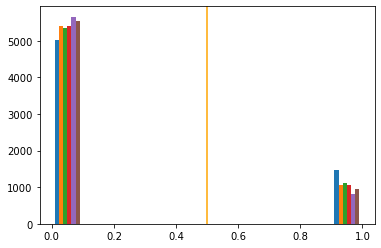

In [29]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [30]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


95.96973440395305

In [31]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [32]:
"{:0.2f}".format(pct_auc)

'97.53'

In [33]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [34]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [35]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [36]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_lstm_2,n_lstm_1,n_dense_2,n_dense_1,n_conv_3,n_conv_2,n_conv_1,maxpooling_pool_size,k_conv_3,k_conv_2,k_conv_1,dropout_2,dropout_1,drop_lstm_2,drop_lstm_1,avepooling_pool_size,activation_dense,activation_conv,mean,std
16,128,128,384,384,512,512,768,2,2,2,3,0.2,0.2,0.02,0.10,2,<tensorflow.python.keras.layers.advanced_activ...,relu,0.944885,0.001534
12,256,256,512,384,512,512,768,2,2,2,3,0.3,0.2,0.10,0.10,3,relu,relu,0.944284,0.000925
11,128,128,512,256,512,256,512,2,2,2,2,0.2,0.2,0.02,0.10,2,<tensorflow.python.keras.layers.advanced_activ...,relu,0.939771,0.002293
18,256,128,512,384,512,256,768,3,2,3,3,0.3,0.2,0.02,0.10,3,elu,relu,0.939188,0.002291
4,128,128,256,512,512,256,512,3,3,2,3,0.3,0.2,0.02,0.10,2,<tensorflow.python.keras.layers.advanced_activ...,relu,0.938416,0.001870
0,256,256,512,384,512,256,512,3,3,2,3,0.3,0.3,0.02,0.10,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.938330,0.003349
14,256,128,256,384,256,256,768,3,2,3,3,0.2,0.2,0.10,0.10,2,elu,relu,0.938107,0.001120
15,128,256,384,384,256,256,768,2,3,3,2,0.3,0.2,0.10,0.02,2,<tensorflow.python.keras.layers.advanced_activ...,relu,0.936700,0.002642
3,256,256,256,512,512,512,512,3,2,3,2,0.2,0.2,0.10,0.02,2,<tensorflow.python.keras.layers.advanced_activ...,<tensorflow.python.keras.layers.advanced_activ...,0.929819,0.005816
17,256,128,384,256,256,256,768,2,3,3,3,0.3,0.2,0.02,0.02,2,relu,<tensorflow.python.keras.layers.advanced_activ...,0.929493,0.007134


## Creating best model from the best param and train it for 60 epochs

In [37]:
rscv_results.best_params_

{'n_lstm_2': 128,
 'n_lstm_1': 128,
 'n_dense_2': 384,
 'n_dense_1': 384,
 'n_conv_3': 512,
 'n_conv_2': 512,
 'n_conv_1': 768,
 'maxpooling_pool_size': 2,
 'k_conv_3': 2,
 'k_conv_2': 2,
 'k_conv_1': 3,
 'dropout_2': 0.2,
 'dropout_1': 0.2,
 'drop_lstm_2': 0.02,
 'drop_lstm_1': 0.1,
 'avepooling_pool_size': 2,
 'activation_dense': <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x252062f3d48>,
 'activation_conv': 'relu'}

In [57]:
n_lstm_2 = 128
n_lstm_1 = 128
n_dense_2= 384
n_dense_1= 384
n_conv_3= 512
n_conv_2= 512
n_conv_1= 768
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
drop_lstm_2 = 0.02
drop_lstm_1 = 0.1
avepooling_pool_size= 2
activation_dense = LeakyReLU()
activation_conv = 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
# model.add(GlobalMaxPooling1D())

# LSTM layers
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, return_sequences=True)) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
output_dir= 'model_ouput/Final-CNN-LSTM'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [59]:
epochs = 120
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/120
228/228 [==============================] - 17s 76ms/step - loss: 0.9483 - accuracy: 0.5963 - val_loss: 0.6727 - val_accuracy: 0.7288
Epoch 2/120
228/228 [==============================] - 17s 73ms/step - loss: 0.5682 - accuracy: 0.7747 - val_loss: 0.4335 - val_accuracy: 0.8223
Epoch 3/120
228/228 [==============================] - 17s 73ms/step - loss: 0.4172 - accuracy: 0.8399 - val_loss: 0.3706 - val_accuracy: 0.8562
Epoch 4/120
228/228 [==============================] - 16s 72ms/step - loss: 0.3481 - accuracy: 0.8662 - val_loss: 0.3244 - val_accuracy: 0.8780
Epoch 5/120
228/228 [==============================] - 16s 71ms/step - loss: 0.3166 - accuracy: 0.8762 - val_loss: 0.3082 - val_accuracy: 0.8779
Epoch 6/120
228/228 [==============================] - 16s 72ms/step - loss: 0.2983 - accuracy: 0.8836 - val_loss: 0.2678 - val_accuracy: 0.9015
Epoch 7/120
228/228 [==============================] - 16s 72ms/step - loss: 0.2806 - accuracy: 0.8920 - val_loss: 0.2774 - val_ac

228/228 [==============================] - 17s 73ms/step - loss: 0.0578 - accuracy: 0.9786 - val_loss: 0.2178 - val_accuracy: 0.9565
Epoch 58/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0519 - accuracy: 0.9804 - val_loss: 0.2299 - val_accuracy: 0.9557
Epoch 59/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0546 - accuracy: 0.9808 - val_loss: 0.2110 - val_accuracy: 0.9565
Epoch 60/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0543 - accuracy: 0.9801 - val_loss: 0.2321 - val_accuracy: 0.9546
Epoch 61/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0536 - accuracy: 0.9807 - val_loss: 0.2144 - val_accuracy: 0.9577
Epoch 62/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0532 - accuracy: 0.9810 - val_loss: 0.2299 - val_accuracy: 0.9506
Epoch 63/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0539 - accuracy: 0.9802 - val_loss: 0.2168 - val_accuracy

228/228 [==============================] - 17s 72ms/step - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.2509 - val_accuracy: 0.9617
Epoch 114/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0257 - accuracy: 0.9910 - val_loss: 0.2644 - val_accuracy: 0.9616
Epoch 115/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0275 - accuracy: 0.9905 - val_loss: 0.2529 - val_accuracy: 0.9589
Epoch 116/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0288 - accuracy: 0.9901 - val_loss: 0.2535 - val_accuracy: 0.9575
Epoch 117/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.2432 - val_accuracy: 0.9622
Epoch 118/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0291 - accuracy: 0.9897 - val_loss: 0.2481 - val_accuracy: 0.9597
Epoch 119/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0300 - accuracy: 0.9899 - val_loss: 0.2594 - val_ac

In [60]:
model.load_weights(output_dir+"/weights.100.hdf5") # 96.32

In [61]:
y_hat = model.predict(X_valid)

In [62]:
len(y_hat)

6476

In [63]:
y_hat[0]

array([1.1243720e-06, 1.6568372e-06, 7.3366004e-07, 3.5447638e-06,
       2.3228047e-06, 9.9999070e-01], dtype=float32)

In [64]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

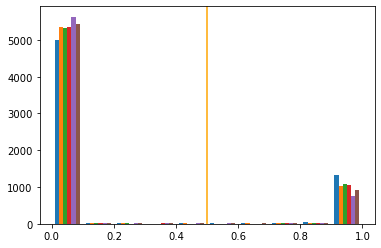

In [65]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [66]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'99.66'

In [67]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'96.22'

In [68]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [69]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [70]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
